역전파 이용한 다층 신경망에서 레이어의 갯수, 노드 수, 활성화 함수 등을 바꿔가면서 자신만의 모델 만들기

- 히든 레이어마다 활성화함수 임의 지정 가능하도록 수정
- epochs 변경(너무 값이 크면 오버피팅 되니 주의)
- batch size 변경
- 시각화

### MNIST 분류 with 역전파


#### Modules Import

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from collections import OrderedDict

#### 데이터 로드

In [ ]:
np.random.seed(42)

mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

num_classes = 10

#### 데이터 전처리

In [ ]:
X_train, X_test = X_train.reshape(-1, 28 * 28).astype(np.float32), X_test.reshape(-1, 28 * 28).astype(np.float32)

# min max scaling: min=0, max=255 => (X - 0) / (255 - 0)
#X_train /= 255.
#X_test /= 255.

y_train = np.eye(num_classes)[y_train] # One hot vector

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000,)


#### Util Functions

In [ ]:
def softmax(x):
  if x.ndim == 2:
    x = x.T
    x = x - np.max(x, axis=0)
    y = np.exp(x) / np.sum(np.exp(x), axis=0)
    return y.T

  x = x - np.max(x)
  return np.exp(x) / np.sum(np.exp(x))

def mean_squared_error(pred_y, true_y):
  return 0.5 * np.sum((pred_y - true_y)**2)

def cross_entropy_error(pred_y, true_y):
  if pred_y.ndim == 1:
    true_y = true_y.reshape(1, true_y.size)
    pred_y = pred_y.reshape(1, pred_y.size)

  if true_y.size == pred_y.size:
    true_y = true_y.argmax(axis=1)

  batch_size = pred_y.shape[0]
  return -np.sum(np.log(pred_y[np.arange(batch_size), true_y] + 1e-7)) / batch_size

def softmax_loss(X, true_y):
  pred_y = softmax(X)
  return cross_entropy_error(pred_y, true_y)

#### Util Classes

##### ReLU

In [ ]:
class ReLU():
  
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x < 0)
    self.out = x.copy()
    self.out[x < 0] = 0
    return self.out

  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout
    return dx

##### Sigmoid

In [ ]:
class Sigmoid():

  def __init__(self):
    self.out = None

  def forward(self, x):
    out = 1 / (1 + np.exp(-x))
    self.out = out
    return out

  def backward(self, dout):
    dx = dout * (1.0 - self.out) * self.out
    return dx

##### Layer

In [ ]:
class Layer():

  def __init__(self, W, b):
    self.W = W
    self.b = b

    self.x = None
    self.origin_x_shape = None
    
    self.dL_dW = None
    self.dL_db = None

  def forward(self, x):
    self.origin_x_shape = x.shape

    x = x.reshape(x.shape[0], -1)
    self.x = x
    out = np.dot(self.x, self.W) + self.b

    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dL_dW = np.dot(self.x.T, dout)
    self.dL_db = np.sum(dout, axis=0)
    dx = dx.reshape(*self.origin_x_shape)
    return dx

#### Softmax

In [ ]:
class Softmax():

  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)

    return self.loss

  def backward(self, dout=1):
    batch_size = self.t.shape[0]

    if self.t.size == self.y.size:
      dx = (self.y - self.t) / batch_size
    else:
      dx = self.y.copy()
      dx[np.arange(batch_size), self.t] -= 1
      dx = dx / batch_size

    return dx

In [ ]:
class MyModel():

  def __init__(self, input_size, hidden_size_list, output_size, activation='relu'):
    self.input_size = input_size
    self.output_size = output_size
    self.hidden_size_list = hidden_size_list
    self.hidden_layer_num = len(hidden_size_list)
    self.params = {}

    self.__init_weights(activation)

    activation_layer = {'sigmoid': Sigmoid, 'relu': ReLU}
    self.layers = OrderedDict()
    for idx in range(1, self.hidden_layer_num + 1):
      self.layers['Layer' + str(idx)] = Layer(self.params['W' + str(idx)], self.params['b' + str(idx)])
      self.layers['Activation_function' + str(idx)] = activation_layer[activation[idx-1]]()

    idx = self.hidden_layer_num + 1

    self.layers['Layer' + str(idx)] = Layer(self.params['W' + str(idx)], self.params['b' + str(idx)])

    self.last_layer = Softmax()

  def __init_weights(self, activation):
    weight_std = None
    all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
    for idx in range(1, len(all_size_list)):
      if activation[idx-1].lower() == "relu":
        weight_std = np.sqrt(2.0 / self.input_size)
      elif activation[idx-1].lower() == 'sigmoid':
        weight_std = np.sqrt(1.0 / self.input_size)

      self.params['W' + str(idx)] = weight_std * np.random.randn(all_size_list[idx-1], all_size_list[idx])
      self.params['b' + str(idx)] = np.random.randn(all_size_list[idx])

  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)

    return x

  def loss(self, x, true_y):
    pred_y = self.predict(x)

    return self.last_layer.forward(pred_y, true_y)

  def accuracy(self, x, true_y):
    pred_y = self.predict(x)
    pred_y = np.argmax(pred_y, axis=1)

    if true_y.ndim != 1:
      true_y = np.argmax(true_y, axis=1)

    accuracy = np.sum(pred_y == true_y) / float(x.shape[0])
    return accuracy

  def gradient(self, x, t):
    self.loss(x, t)

    dout = 1
    dout = self.last_layer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)

    grads = {}
    for idx in range(1, self.hidden_layer_num + 2):
      grads['W' + str(idx)] = self.layers['Layer' + str(idx)].dL_dW
      grads['b' + str(idx)] = self.layers['Layer' + str(idx)].dL_db

    return grads

#### Hyper Parameters

In [ ]:
epochs = 2000
learning_rate = 1e-3
batch_size = 200
train_size = X_train.shape[0]

#### 모델 생성 및 학습

In [ ]:
model = MyModel(28*28, [128, 64, 32], 10, activation=['relu', 'relu', 'relu', 'relu'])

In [ ]:
train_loss_list = []
train_acc_list = []
test_acc_list = []

In [ ]:
for epoch in range(epochs):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = X_train[batch_mask]
  y_batch = y_train[batch_mask]

  grad = model.gradient(x_batch, y_batch)

  for key in model.params.keys():
    model.params[key] -= learning_rate * grad[key]

  loss = model.loss(x_batch, y_batch)
  train_loss_list.append(loss)

  if epoch % 100 == 0:
    train_acc = model.accuracy(X_train, y_train)
    test_acc = model.accuracy(X_test, y_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print("Epoch: {} Train Accuracy: {:.4f} Test Accuracy: {:.4f}".format(epoch+1, train_acc, test_acc))

Epoch: 1 Train Accuracy: 0.1080 Test Accuracy: 0.1061
Epoch: 101 Train Accuracy: 0.6116 Test Accuracy: 0.6267
Epoch: 201 Train Accuracy: 0.7405 Test Accuracy: 0.7498
Epoch: 301 Train Accuracy: 0.7888 Test Accuracy: 0.7988
Epoch: 401 Train Accuracy: 0.8197 Test Accuracy: 0.8272
Epoch: 501 Train Accuracy: 0.8404 Test Accuracy: 0.8460
Epoch: 601 Train Accuracy: 0.8554 Test Accuracy: 0.8602
Epoch: 701 Train Accuracy: 0.8640 Test Accuracy: 0.8687
Epoch: 801 Train Accuracy: 0.8682 Test Accuracy: 0.8730
Epoch: 901 Train Accuracy: 0.8772 Test Accuracy: 0.8804
Epoch: 1001 Train Accuracy: 0.8829 Test Accuracy: 0.8866
Epoch: 1101 Train Accuracy: 0.8842 Test Accuracy: 0.8901
Epoch: 1201 Train Accuracy: 0.8912 Test Accuracy: 0.8934
Epoch: 1301 Train Accuracy: 0.8944 Test Accuracy: 0.8983
Epoch: 1401 Train Accuracy: 0.8981 Test Accuracy: 0.9025
Epoch: 1501 Train Accuracy: 0.9008 Test Accuracy: 0.9060
Epoch: 1601 Train Accuracy: 0.9020 Test Accuracy: 0.9062
Epoch: 1701 Train Accuracy: 0.9067 Test Acc

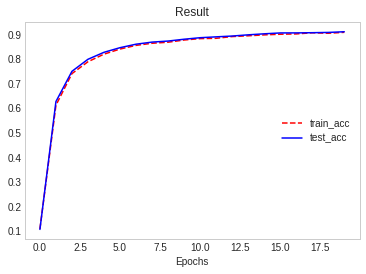

In [ ]:
plt.plot(np.arange(1000//50), train_acc_list, 'r--', label='train_acc')
plt.plot(np.arange(1000//50), test_acc_list, 'b', label='test_acc')

plt.title('Result')
plt.xlabel('Epochs')
plt.legend(loc=5)
plt.grid()
plt.show()

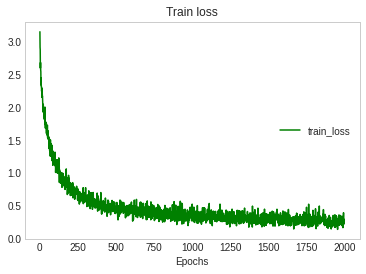

In [ ]:
plt.plot(np.arange(2000), train_loss_list, 'green', label='train_loss')
plt.title('Train loss')
plt.xlabel('Epochs')
plt.legend(loc=5)
plt.grid()
plt.show()